# SQLite database for data hosting
***
In this project, we used the Million Playlists Dataset from Spotify website. They were stored in a bundle of json files of Python dictionaries which had information about individual playlists and all tracks that each playlists contained. To organize the data in a form that was easy to work with, we built a SQLite database and registered information about playlists and tracks into tables.
***
## Load libraries

In [1]:
import sys, os
import sqlite3
import pandas as pd
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Create the database and tables
***
We built the database ***spotifyDB.db*** and created two tables for hosting tracks and playlists.

In [2]:
# create a new database by connecting to it
conn = sqlite3.connect("spotifyDB.db")
cur = conn.cursor()

In [ ]:
# create the tracks table
cur.execute('''CREATE TABLE IF NOT EXISTS tracks (track text PRIMARY KEY,
         track_name text, album text, album_name text, artist text, artist_name text, 
         duration_ms integer, playlist_member text, num_member integer
         );''')

conn.commit()

In [ ]:
# create playlists table
cur.execute('''CREATE TABLE IF NOT EXISTS playlists (playlist_id INTEGER PRIMARY KEY AUTOINCREMENT,
         playlist_name TEXT, collaborative TEXT, modified_at INTEGER, num_tracks INTEGER, num_albums INTEGER,
         num_artists INTEGER, num_followers INTEGER, num_edits INTEGER, playlist_duration_ms INTEGER, 
         tracks TEXT);''')

conn.commit()

## Register playlist-track information into tables
***
### Function definitions
First we defined several functions to process and prepare data for insertion.

- ***process_playlist*** extracts playlists information from Python dictionaries.

- ***clean_uri*** removes extra information and returns cleaned Spotify uri.

- ***process_tracks_into_df*** processes track information in DataFrames.

- ***prepare_tracks_update*** prepares track dataFrame for batch insertion and update.

In [ ]:
def process_playlist(playlist_dict):
    columns = ['playlist_name','collaborative','modified_at','num_tracks','num_albums',
               'num_artists','num_followers','num_edits','duration_ms']
    
    playlist = {}
    
    for col in columns:
        if col in playlist_dict.keys():
            playlist[col] = playlist_dict[col]
        else:
            playlist[col] = None
            
    if 'name' in playlist_dict.keys() and playlist['playlist_name'] == None:
        playlist['playlist_name'] =playlist_dict['name']
        
    all_track_uri = [tr['track_uri'].split(':')[-1] for tr in playlist_dict['tracks']]
    all_track_uri = ','.join(set(all_track_uri)) # take unique tracks
    playlist['tracks'] = all_track_uri
    playlist['playlist_duration_ms'] = playlist.pop('duration_ms')
    
    playlist_df = pd.DataFrame(playlist, index=[0])
    playlist_df = playlist_df.set_index('playlist_name')
    
    return playlist_df

In [ ]:
def clean_uri(track,uri):
    if type(track[uri])!=type(None):
        cleaned_uri = track[uri].split(':')[-1]
    elif type(track[uri])==type(None):
        cleaned_uri = ''
    return cleaned_uri 

In [ ]:
def process_tracks_into_df(tracks, playlist_id):
    # convert tracks into dataframe
    tracks_df = pd.DataFrame.from_dict(tracks)
    # remove duplicates of tracks
    tracks_df = tracks_df.drop_duplicates('track_uri')
    # clean up uri
    tracks_df['track'] = tracks_df.apply(lambda x: clean_uri(x,'track_uri'), axis=1)
    tracks_df['album'] = tracks_df.apply(lambda x: clean_uri(x,'album_uri'), axis=1)
    tracks_df['artist'] = tracks_df.apply(lambda x: clean_uri(x,'artist_uri'), axis=1)
    # drop unnecessary columns
    tracks_df = tracks_df.drop(['pos','track_uri','album_uri','artist_uri'], axis = 1)
    # set index to track
    tracks_df = tracks_df.set_index('track')
    # add playlist membership
    tracks_df['playlist_member'] = str(playlist_id)
    # add number of membership
    tracks_df['num_member'] = 1
    
    return tracks_df

In [ ]:
def prepare_tracks_update(tracks_df, playlist_id, conn, cur):
    # make keys of all tracks
    tracks_in_playlist = list(tracks_df.index)
    keys = tracks_in_playlist
    keys = '\',\''.join(keys)
    keys = "('"+keys+"')"
    
    # fetch existing keys
    query = 'SELECT * FROM tracks WHERE track IN {};'.format(keys)
    existing_tuples = pd.read_sql_query(query, conn)
    
    # if none of the track exists, return whole tracks_df
    if len(existing_tuples) == 0:
        tracks_df_new = tracks_df.copy()
    
    # if there are pre-existing tracks
    elif len(existing_tuples) > 0:
        # expand playlist membership
        existing_tuples['playlist_member'] = existing_tuples.apply(
            lambda x: x.playlist_member + ',' + str(playlist_id), axis=1)
        existing_tuples['num_member'] = existing_tuples.apply(
            lambda x: x.num_member + 1, axis=1)
        existing_tuples= existing_tuples.set_index('track')
        
        # delete existing keys
        query = 'DELETE FROM tracks WHERE track IN {};'.format(keys)
        cur.execute(query)
        conn.commit()

        # extract non-existing tracks
        existing_mask = tracks_df.index.isin(existing_tuples.index)
        tracks_df_new = tracks_df.iloc[~existing_mask].copy()
        
        # combine non-exisitng tracks with updated exisiting tracks
        tracks_df_new = tracks_df_new.append(existing_tuples)
        
    return tracks_df_new

## Data registration
***
We subselected 50% of the files and register them into tables.

In [ ]:
# prepare paths to the files
mpd_path ='PATH TO DATA FOLDER'
playlist_path = []

for path, subdirs, files in os.walk(mpd_path):
    for name in files:
        if name.endswith('.json'):
            playlist_path.append(os.path.join(path, name))

# subselect half of the files
playlist_path_sub = playlist_path[:-1:2].copy()

len(playlist_path_sub)

In [ ]:
#### Main scripts for data registration ####

# prelocate list to host processed and unprocessed files
processed_files = []
unprocessed_files = playlist_path.copy()

# loop over file subsets
for file_ind, filepath in enumerate(playlist_path_sub):  
    # keep track of files that have been processed
    print('File number = ', file_ind)
    unprocessed_files.remove(filepath)
    processed_files.append(filepath)
    
    # load the file
    with open(filepath, "r") as fd:
        data = json.load(fd)
    
    # find number of playlists
    num_playlist = len(data['playlists'])
    
    # loop over all playlists
    for playlist_dict in data['playlists']:
        # process playlist
        this_playlist = process_playlist(playlist_dict)
        
        # insert playlist into playlists table
        this_playlist.to_sql('playlists', conn, if_exists='append')
        
        # get playlist_id (the most recent inserted (max playlist_id))
        query_max_id = 'SELECT MAX(playlist_id) FROM playlists;'
        playlist_id = cur.execute(query_max_id).fetchall()[0][0]
        
        # get list of all tracks and process into dataframe
        these_tracks = playlist_dict['tracks']
        tracks_df = process_tracks_into_df(these_tracks, playlist_id)
        
        # get tracks dataframe for insertion
        tracks_df_to_insert = prepare_tracks_update(tracks_df, playlist_id, conn, cur)
        
        # insert tracks dataframe into tracks table
        tracks_df_to_insert.to_sql('tracks', conn, if_exists='append')

# Visualization of tables and EDA
***
After registering the data, we can take a look at the tables and simple statistics of them.

## Tracks table
***
Here is how the tracks table look like:

In [4]:
display(pd.read_sql_query("SELECT * FROM tracks WHERE num_member > 2 LIMIT 10;", conn))

,track,track_name,album,album_name,artist,artist_name,duration_ms,playlist_member,num_member
0,4orbjP0tCRTyz1mzaBBNfe,Tiny Prayers,5SThok56qPZWKBkCgo1jvX,LP3,7emzuJJA7yCSe3lFP0geRX,Restorations,270813,"31,2007,2104",3
1,3ef2Xwb3miZB3uQrwk02CY,Lose My Number,2fHfgG1QPIUgkh9aGrLj2i,Lose My Number,2NDqx1z4TTkFr0QOnk8nX3,Haley Mae Campbell,218526,"4596,10318,11660",3
2,4gNtnaq83U4wxI4ZA0wJpY,Supne,4Ynd6YaRlyUU9J8Ew6DXpv,Supne,6zZrFenNe3YPttxZsnQQs1,Akhil,229537,"4800,10539,13872",3
3,5NIN7nEnHkvDjttYPiAv0l,Oye Como Va,1de9ZEWcUihEjpfseRslwm,Greatest Hits,57EAEbnYbr1PFzadw9Zvgi,Fattburger,244120,"2916,13633,17009",3
4,1PtXb911Zu4ZEtS0Ury1Yy,Fallen Angel,2UzKuFTNWbXd5xyicK2h3K,Cast Of Thousands,0TJB3EE2efClsYIDQ8V2Jk,Elbow,247933,"3480,11029,17192",3
5,1NChReYoZE87Tm4lSWbIsy,Don't Stop,6uL7RW7IgFL9naC4Z4MNqm,Don't Stop,62eXubdnqpsK7IFweKENa6,London Future,215586,"7985,11363,13502,17860",4
6,3XuLKKhDXHO2z5iAj8jTn8,The Broken Promise/O'Mahoney's/Murphy's Reel,7nivc3NHA0HbmVF1KKajmD,Herding Cats,5dlzTgw97q5k5ws89Ww1UK,Gaelic Storm,275133,"4207,10906,13305,18293",4
7,1WgYHGlEsnPf1fYRvBBvoK,Fix You,63lHCog4E73RzcCGEpbrj7,Masters of Chant: Chapter VI,5QO1NNCLglKxgogzx6XLJn,Gregorian,303840,"1043,15903,16372,20553",4
8,6QAu3FW5u1kpzagMkM4a4T,Great Is the Lord,6REyEw2vFqrh6YA7cYF8uD,God With Us,3YCKuqpv9nCsIhJ2v8SMix,Elevation Worship,243666,"8193,10145,20676",3
9,0L9CaGzVcW61cJFOS7uaFC,Pure,0bRZr4eXClow3U7OGB4iyh,Souvenir,2eTosKYENiHrq3S8d1S0it,David Keller,480000,"4318,9224,20886",3


The playlist IDs that each track was a member of were stored in the table, which can be used to link to the playlists table.

### Number of playlist membership
***
We can look at the statisitcs of number of playlist membership of tracks. Here we are showing only tracks that belonged to a least 2 playlists, which consist of 2.4% of all the tracks (799,008 over 32,705,544 tracks). As we can see, among those tracks, the mean was ~40, and the distribution was really right skewed.

,num_member
count,799008.000000
mean,39.928869
std,296.983336
min,2.000000
25%,2.000000
50%,4.000000
75%,12.000000
max,22839.000000


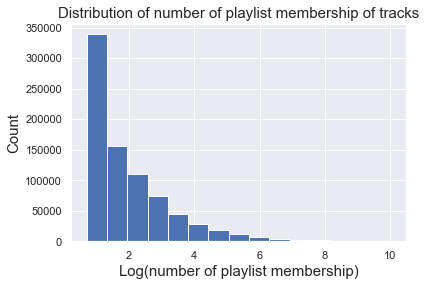

In [6]:
sns.set()

n_tr = pd.read_sql_query("select num_member FROM tracks WHERE num_member > 1;", conn)
display(n_tr.describe())

mem = pd.read_sql_query("select num_member FROM tracks WHERE num_member > 1;", conn)
mem.describe()
plt.hist(np.log(np.array(mem)),bins = 15)
plt.xlabel('Log(number of playlist membership)', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('Distribution of number of playlist membership of tracks', fontsize = 15);

## Playlists table
***
This is our playlists table. The Spotify uri's for all tracks that each playlist contained were stored in the table.

In [9]:
display(pd.read_sql_query("SELECT * FROM playlists WHERE num_followers > 10 LIMIT 5;", conn))

,playlist_id,playlist_name,collaborative,modified_at,num_tracks,num_albums,num_artists,num_followers,num_edits,playlist_duration_ms,tracks
0,242,Tegan and Sara,false,1464998400,151,25,7,18,17,29003627,"3P4skIO0EF1c3C93GNwQpa,5QJ0W0dYxu3PuaO4Fo84sp,..."
1,256,Christmas Mix,false,1387152000,32,28,25,22,3,6772221,"5QunGzRKeXjEHPfaG6BScP,5EDUhfn84BfHrS26RZ5vef,..."
2,297,Worship,false,1508198400,35,31,26,11,19,8320641,"1pnrwYOFzmP7f1P77QsspG,67JFpAWQvohcwoYYsDqP5l,..."
3,366,Chill Rock,false,1460332800,128,114,90,15,18,29409896,"0sgpDWD8lFKaJNSFuhULyq,46GGxd8TVRt6FjUBfCavVT,..."
4,517,smooth jams,false,1509062400,188,171,140,13,41,48588746,"1z35crfs2inLHpArGKuHFd,68ZD7M5tOBBM0N5XWRECoD,..."


### Number of tracks in playlists
***
We can look at the number of tracks contained in each playlists. On average, each playlist had 66 tracks, and again it was a right skewed distribution.

,num_tracks
count,500000.000000
mean,66.296618
std,53.685938
min,5.000000
25%,26.000000
50%,49.000000
75%,91.000000
max,376.000000


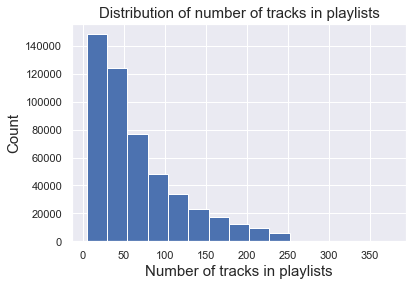

In [10]:
n_pl = pd.read_sql_query("SELECT num_tracks FROM playlists;", conn)
display(n_pl.describe())

plt.hist(np.array(n_pl),bins = 15)
plt.xlabel('Number of tracks in playlists', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('Distribution of number of tracks in playlists', fontsize = 15);

We can kind of get a sense here that this dataset is very sparse. We had a huge number of playlists and tracks, but the chance that one playlist contained one particular track was pretty low. 

## Closing cursor and disconnecting database

In [11]:
# close cursor and connection
cur.close()
conn.close()